<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/ML/ARIMA_and_MLP(residual).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import io
import requests
# lib to plot the data
import matplotlib.pyplot as plt
# lib to use the decompositio in the time series
from statsmodels.tsa.seasonal import seasonal_decompose
# lib to use the acf and pcf correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# lib to organize the data in data frame
from pandas import DataFrame
# lib to import the stocastic basic models
from statsmodels.tsa.api import Holt
# lib to import the ar model
from statsmodels.tsa.ar_model import AR

from statsmodels.tsa.arima_model import ARMA, ARIMA

from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE

# Constants

In [0]:
H = 6
V = 12

# Monthly Sunspots

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985)

## Data

In [28]:
url='https://raw.githubusercontent.com/jamissonfreitas/IN1167/master/monthly-sunspots.csv'
data = requests.get(url).content
data = data.decode('utf-8').replace("\"","").split('\n')
data = [d.strip().split(',') for d in data][1:-1]
data[:5]

[['1749-01', '58.0'],
 ['1749-02', '62.6'],
 ['1749-03', '70.0'],
 ['1749-04', '55.7'],
 ['1749-05', '85.0']]

In [29]:
df = pd.DataFrame(
    data, 
    columns=['Month', 'Sunspots']
) 
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m', errors='coerce')
df = df.set_index(df['Month'])
serie = df['Sunspots']
serie[:10]

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
1749-06-01    83.5
1749-07-01    94.8
1749-08-01    66.3
1749-09-01    75.9
1749-10-01    75.5
Name: Sunspots, dtype: object

## Plot Serie

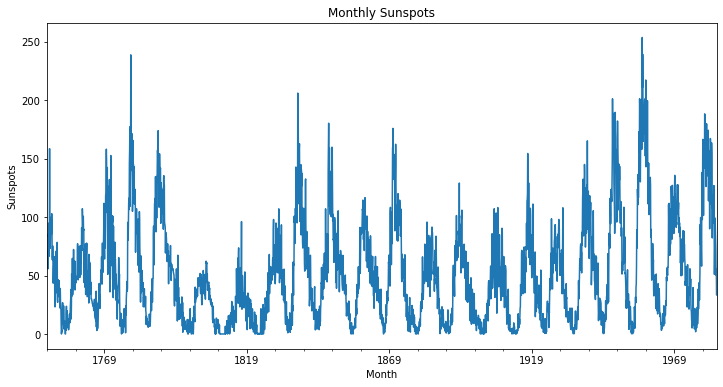

In [30]:
serie = serie.astype(float)
serie.plot(figsize=(V,H))
plt.title('Monthly Sunspots')
plt.ylabel('Sunspots')
plt.xlabel('Month')
plt.show()

In [0]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y
    
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [0]:
serie_normalizada = normalizar_serie(serie)

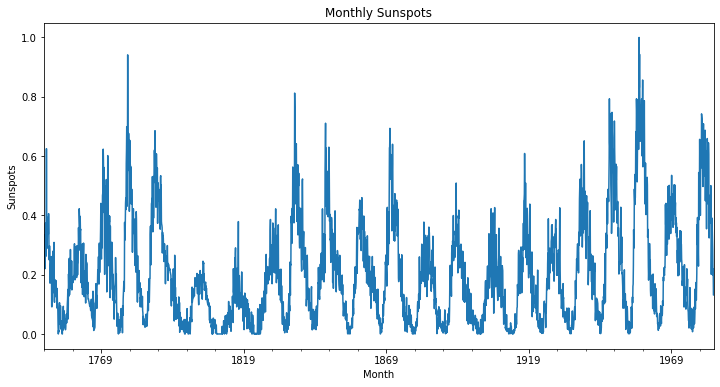

In [48]:
serie_normalizada.plot(figsize=(V,H))
plt.title('Monthly Sunspots')
plt.ylabel('Sunspots')
plt.xlabel('Month')
plt.show()

### Diff

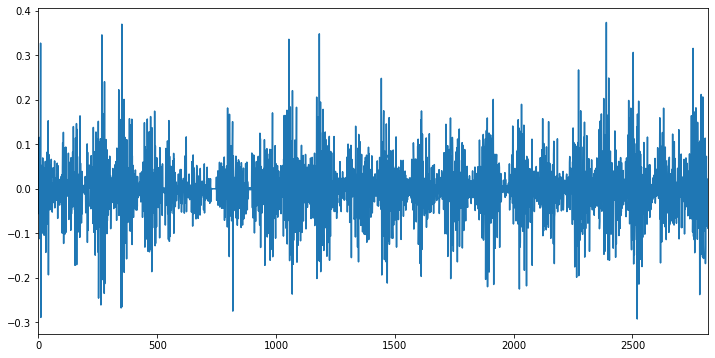

In [75]:
import numpy as np
s_diff = np.diff(serie_normalizada)
s_diff = pd.Series(s_diff)
s_diff.plot(figsize=(V,H))

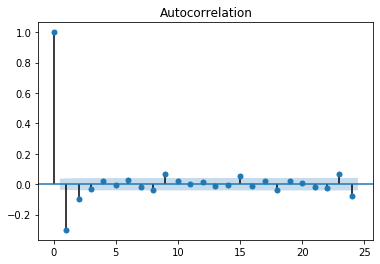

In [76]:
plot_acf(s_diff, lags=24)
plt.show()

## ACF

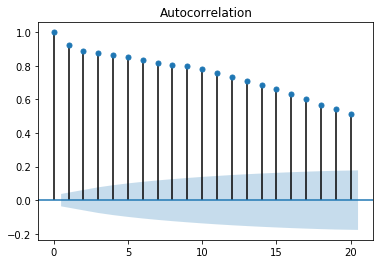

In [77]:
plot_acf(serie, lags=20)
plt.show()

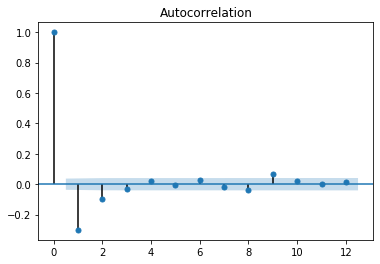

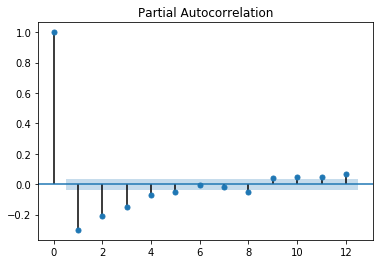

In [78]:
p = plot_acf(s_diff, lags=12)

p = plot_pacf(s_diff, lags=12)

## Seasonal decompose

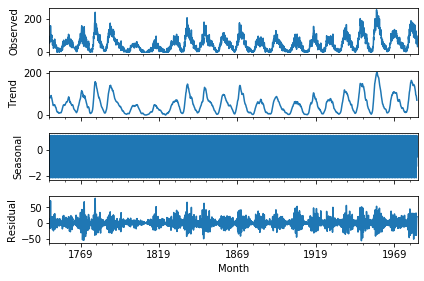

In [80]:
decompose = seasonal_decompose(serie, model='additive')
decompose.plot()
plt.show()

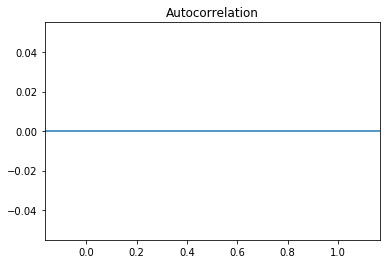

In [81]:
plot_acf(decompose.resid, lags=36)
plt.show()

## Data train and test

In [82]:
size = len(serie)
print(size)
l = int((7*size)/10)
print(l)

# original serie
serie_train = serie[:l]
serie_test = serie[l:]

size = len(s_diff)
print(size)
l = int((7*size)/10)
print(l)

# diff serie
s_diff_train = s_diff[:l]
s_diff_test = s_diff[l:]

2820
1974
2819
1973


## ARIMA

In [83]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = ARIMA(s_diff_train, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue
              
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -5580.19210 | order: (3, 0, 2)


In [84]:
# train ARIMA
model = ARIMA(s_diff_train, order=(3, 0, 2))
model_fitted = model.fit()

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

lags used:  3
parameters:  const     -0.000128
ar.L1.y   -0.771442
ar.L2.y    0.152670
ar.L3.y   -0.023778
ma.L1.y    0.322664
ma.L2.y   -0.610676
dtype: float64


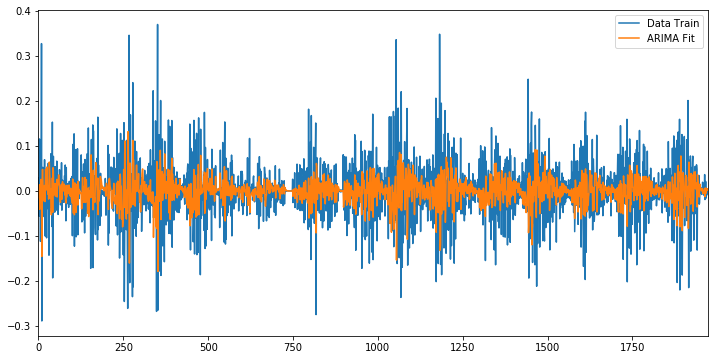

aic: -5528.95810
MSE =  0.007843663514953678


In [85]:
plt.figure(figsize=(V,H))

# plot data train and test
s_diff_train.plot(label='Data Train')

#s_diff_test.plot(label='Data Test')

predict_train = model_fitted.predict(start=s_diff_train.index[0], end=len(s_diff_train), dynamic=False)
predict_train.plot(label='ARIMA Fit')

#predict = model_fitted.predict(start=s_diff_test.index[0], end=s_diff_test.index[-1], dynamic=False)
#predict.plot(label='ARIMA Forecasting')

#to show
plt.legend()
plt.show()

print('aic: {:6.5f}'.format(model_fitted.aic))

print('MSE = ', mean_squared_error(s_diff_train, predict_train[1:]))

In [86]:
print(model_fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1973
Model:                     ARMA(3, 2)   Log Likelihood                2771.479
Method:                       css-mle   S.D. of innovations              0.059
Date:                Sun, 10 Nov 2019   AIC                          -5528.958
Time:                        01:38:02   BIC                          -5489.847
Sample:                             0   HQIC                         -5514.587
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.220      0.826      -0.001       0.001
ar.L1.y       -0.7714      0.078     -9.857      0.000      -0.925      -0.618
ar.L2.y        0.1527      0.062      2.459      0.0

### Residuo

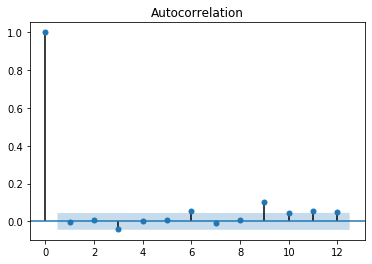

In [87]:
p = plot_acf(model_fitted.resid, lags=12)

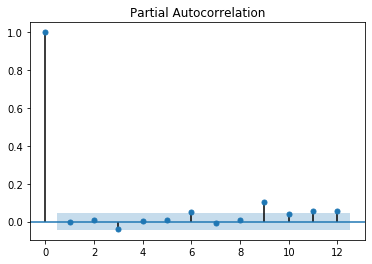

In [88]:
p = plot_pacf(model_fitted.resid, lags=12)

<Figure size 864x432 with 0 Axes>

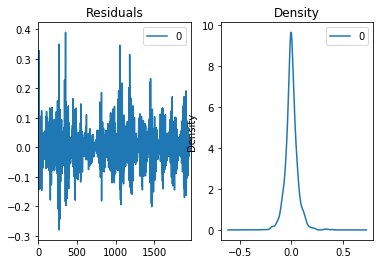

In [89]:
plt.figure(figsize=(V,H))

# Plot residual errors
residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# MLP

In [0]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [126]:
qtd_lags = 5
janelas = gerar_janelas(qtd_lags, residuals.values)
janelas

array([[ 0.01825212,  0.03526818, -0.04046388,  0.10187646,  0.03503512,
         0.07124547],
       [ 0.03526818, -0.04046388,  0.10187646,  0.03503512,  0.07124547,
        -0.07586982],
       [-0.04046388,  0.10187646,  0.03503512,  0.07124547, -0.07586982,
         0.01240315],
       ...,
       [-0.00683784, -0.01325277,  0.01436364, -0.0109166 , -0.00111068,
        -0.01076821],
       [-0.01325277,  0.01436364, -0.0109166 , -0.00111068, -0.01076821,
        -0.0034581 ],
       [ 0.01436364, -0.0109166 , -0.00111068, -0.01076821, -0.0034581 ,
        -0.00608085]])

In [0]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [128]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(janelas, 0.70, perc_val = 0.15)

Particao de Treinamento: 0 1376
Particao de Validacao: 1376 1671
Particao de Teste: 1671 1967


In [0]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
    neuronios =  [10, 30, 50, 100, 200] 
    func_activation =  ['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs', 'sgd', 'adam']
    max_iteracoes = [100, 1000, 10000]
    learning_rate = ['constant', 'invscaling', 'adaptive']
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):  
                          print('Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])


                          for e in range(0,num_exec):
                              mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], 
                                                 activation=func_activation[j], 
                                                 solver=alg_treinamento[l], 
                                                 max_iter = max_iteracoes[m], 
                                                 learning_rate=learning_rate[n])
                                
                                
                              mlp.fit(x_train, y_train)
                              predict_validation = mlp.predict(x_val)
                              mse = MSE(y_val, predict_validation)

                              if mse < best_result:
                                  best_result = mse
                                  print('Melhor MSE:', best_result)
                                  select_model = mlp    
    
    return select_model

In [130]:
modelo = treinar_mlp(x_train, y_train, x_val, y_val, 2)

Qtd de Neuronios 10 Func. Act identity
Melhor MSE: 0.0032383482054125223
Qtd de Neuronios 10 Func. Act identity
Melhor MSE: 0.003231693214239122
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0032269897902618885
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0032134364678637
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act t

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Melhor MSE: 0.003192912075274846
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Fu

## Test

In [0]:
predict_train = modelo.predict(x_train)
predict_val = modelo.predict(x_val)
predict_test = modelo.predict(x_test)

In [0]:
previsoes_train = np.hstack(( predict_train, predict_val))
target_train = np.hstack((y_train, y_val))

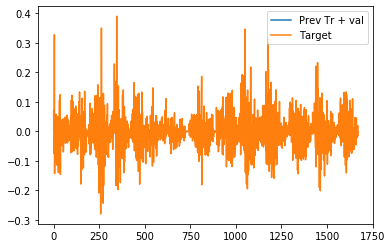

In [133]:
plt.plot(previsoes_train, label = 'Prev Tr + val')
plt.plot(target_train, label='Target')
plt.legend(loc='best')
plt.show()

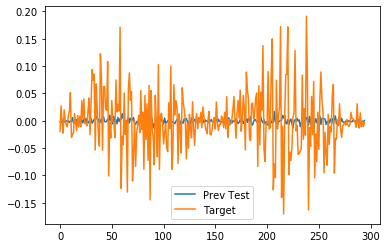

In [134]:
plt.plot(predict_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()

# ARIMA + MLP (residuo)

In [0]:
predict_train_arima = model_fitted.predict(start=s_diff_train.index[0], end=len(s_diff_train), dynamic=False)
predict_train_mlp = modelo.predict(np.concatenate((x_train, x_val, x_test)))

In [136]:
predict_train_arima

0      -0.000128
1      -0.006111
2      -0.015880
3       0.013569
4      -0.040945
          ...   
1969    0.001312
1970    0.005034
1971    0.002535
1972    0.003141
1973    0.001911
Length: 1974, dtype: float64

In [137]:
len(predict_train_mlp)

1966

In [0]:
predict_result = predict_train_arima[8:] + predict_train_mlp

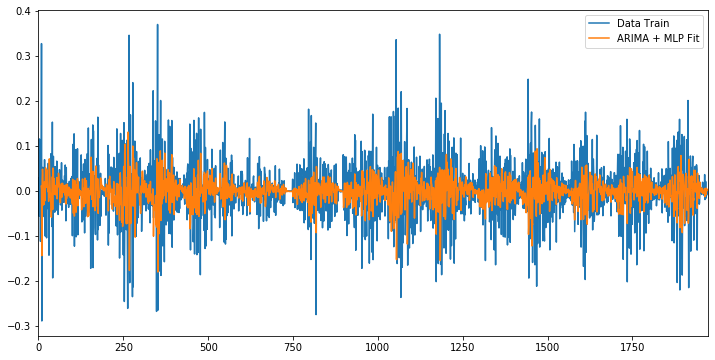

aic: -5528.95810
MSE =  0.007925047625161994


In [140]:
plt.figure(figsize=(V,H))

# plot data train and test
s_diff_train.plot(label='Data Train')

predict_result.plot(label='ARIMA + MLP Fit')

#to show
plt.legend()
plt.show()

print('aic: {:6.5f}'.format(model_fitted.aic))

print('MSE = ', mean_squared_error(s_diff_train[8:], predict_result[1:]))